In [8]:
from graph_traffic.model_selection import get_node_ids
from graph_traffic.config import data_path, project_path
import pandas as pd
import matplotlib.pyplot as plt
from graph_traffic.custom_transformer import bank_holidays
import numpy as np
from IPython.display import Image

node_id = get_node_ids()[0]
node_id

4959

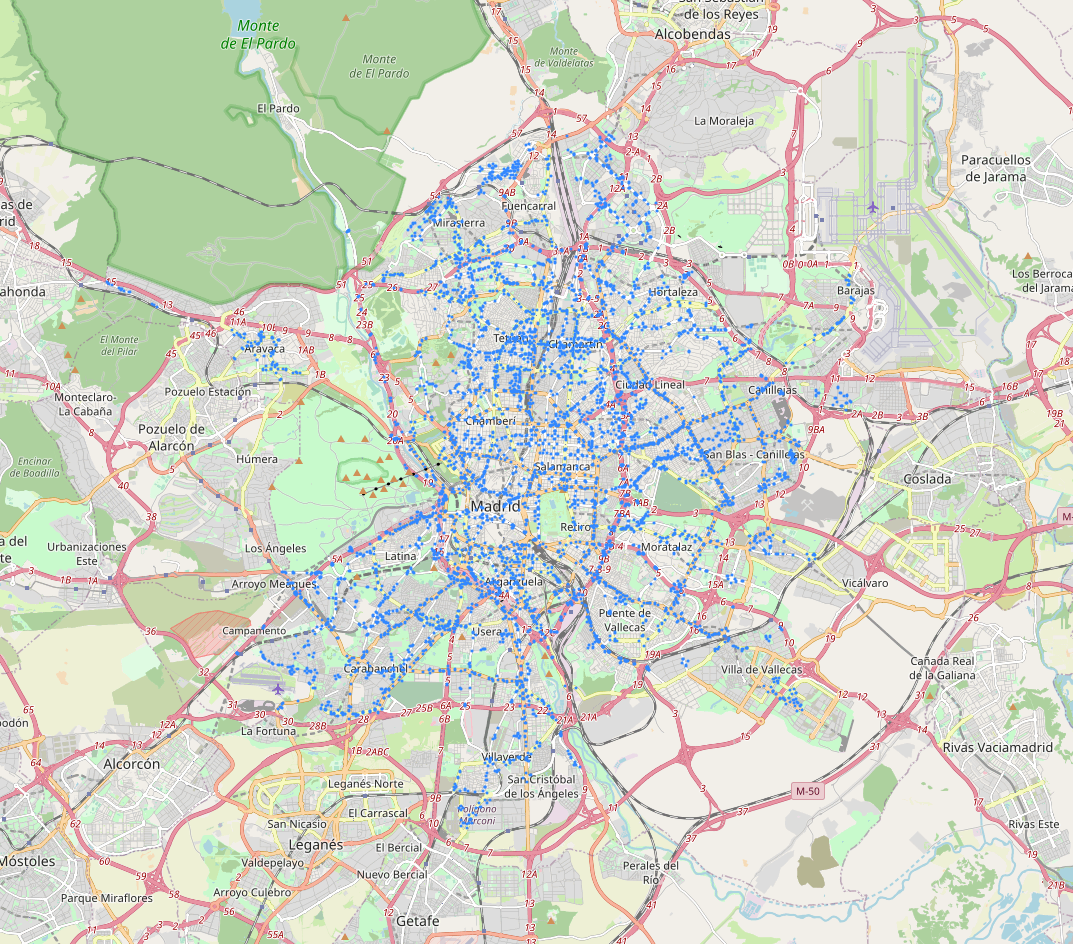

In [9]:
Image(f"{project_path}/figures/maps/all_point.png")

## 1. Die Daten lesen

In [10]:
df = pd.read_csv(f"{data_path}/03-by-location/traffic/{node_id}.csv", usecols=["fecha", "intensidad", "ocupacion", "vmed"], parse_dates=["fecha"])
df.columns = ["date", "cars_per_hour", "percentage_time_busy", "avg_speed"]
df = df.set_index("date")
df.head(10)

,cars_per_hour,percentage_time_busy,avg_speed
date,,,
2019-01-01 00:00:00,23.0,8.0,0.0
2019-01-01 00:15:00,20.0,5.0,0.0
2019-01-01 00:30:00,29.0,11.0,0.0
2019-01-01 00:45:00,30.0,10.0,0.0
2019-01-01 01:00:00,24.0,10.0,0.0
2019-01-01 01:15:00,22.0,5.0,0.0
2019-01-01 01:30:00,23.0,2.0,0.0
2019-01-01 01:45:00,24.0,2.0,0.0
2019-01-01 02:00:00,22.0,10.0,0.0


# 1. Explorative Analyse

Überblick über alle die Daten

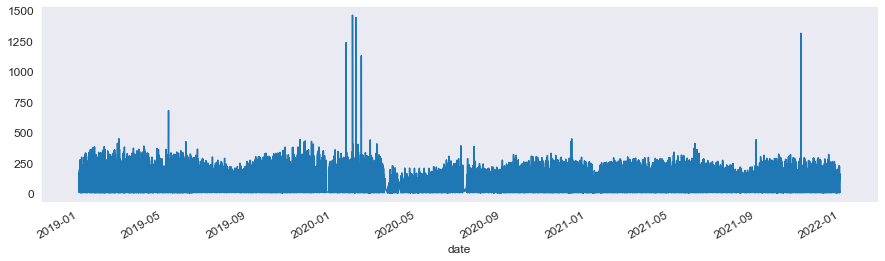

In [11]:
fig, ax = plt.subplots(figsize=(15, 4))
df.cars_per_hour.plot(ax=ax)
plt.show()

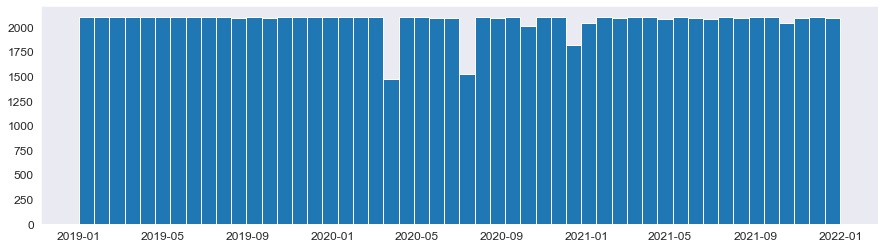

In [12]:
fig, ax = plt.subplots(figsize=(15, 4))
plt.hist(df.index.values, bins=50)
plt.show()

**Im Februar - April 2020**

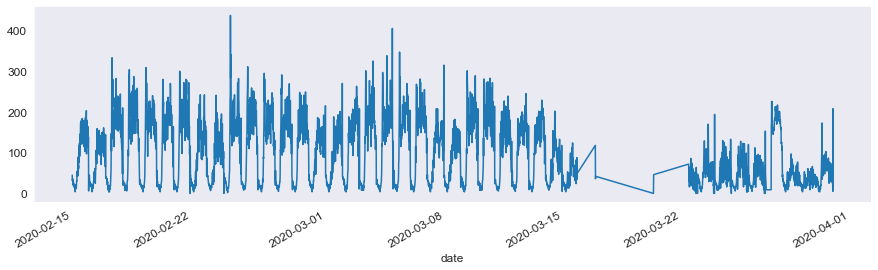

In [13]:
fig, ax = plt.subplots(figsize=(15, 4))
df.loc["2020-02-15": "2020-03-30"].cars_per_hour.plot(ax=ax)
plt.show()

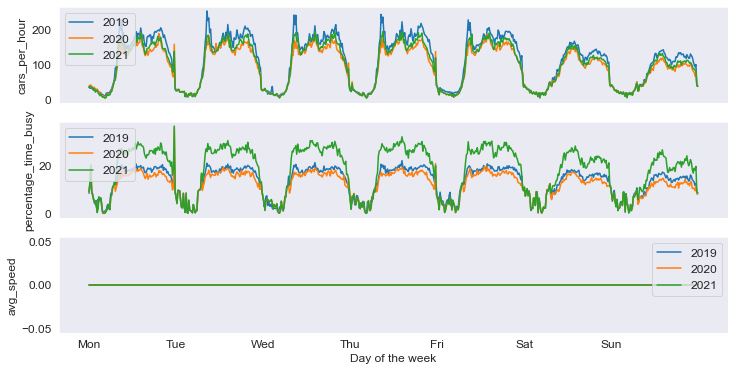

In [14]:
df["weekday"] = df.index.weekday
df["hour"] = df.index.hour + df.index.minute / 60
df["year"] = df.index.year

weekdays = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

df_year = df.groupby(["year", "weekday", "hour"]).mean()
fig, axs = plt.subplots(3, 1, figsize=(12, 3*2), sharex=True)
for i, target in enumerate(["cars_per_hour", "percentage_time_busy", "avg_speed"]):
    ax = axs[i]
    for year in df_year.index.unique(level="year"):
        df_year.loc[year][target].plot(ax=ax, label=year)
    _ = ax.set(
        xticks=[i * 4* 24 for i in range(7)],
        xticklabels=weekdays,
        xlabel="Day of the week",
        ylabel=target,
    )
    ax.legend()
plt.show()

## Verhältnis der unterschiedlichen Verkehrsvariablen?

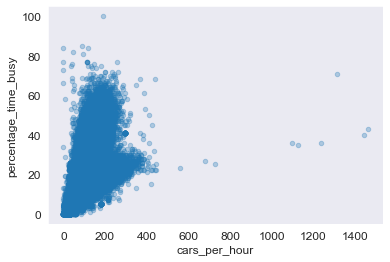

In [15]:
df.plot.scatter("cars_per_hour", "percentage_time_busy", alpha=0.3)
plt.show()

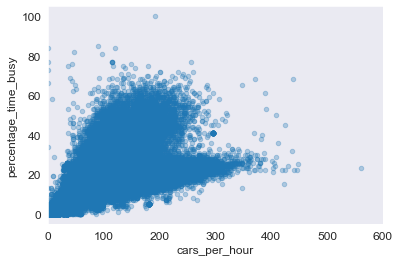

In [16]:
fig, ax = plt.subplots()
df.plot.scatter("cars_per_hour", "percentage_time_busy", alpha=0.3, ax=ax)
ax.set_xlim(0, 600)
plt.show()

### Wir werden verscuhen, die Variable `percentage_time_busy` vorherzusagen

### Wir werden auch meteorologische Variablen benutzen

In [17]:
meteo = pd.read_csv(f"{data_path}/03-by-location/meteo/estacion-56.csv", parse_dates=["fecha"],
                    usecols=["fecha", "velocidad_viento", "temperatura", "precipitacion"])
meteo.columns = ["date", "wind_speed", "temperature", "rain"]
meteo = meteo.set_index("date")
meteo.head()

,wind_speed,temperature,rain
date,,,
2019-01-01 01:00:00,0.68,2.6,0.0
2019-01-01 02:00:00,0.69,2.5,0.0
2019-01-01 03:00:00,0.70,1.7,0.0
2019-01-01 04:00:00,0.70,1.1,0.0
2019-01-01 05:00:00,0.66,1.2,0.0


## Wie sehen die meteorologische Variablen aus?

C:\Users\Bened\AppData\Local\Temp\ipykernel_3028\2925317257.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  meteo.plot(subplots=True, ax=ax)


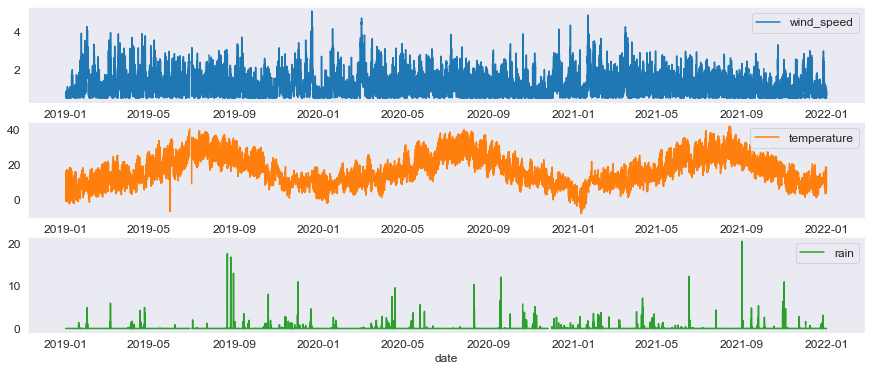

In [18]:
fig, ax = plt.subplots(figsize=(15, 6))
meteo.plot(subplots=True, ax=ax)
plt.show()

# 2. Daten von verkehr und meteorologischen Daten zusammenstellen

In [19]:
df = pd.merge(df, meteo, on="date", how="outer")
df.head(10)

,cars_per_hour,percentage_time_busy,avg_speed,weekday,hour,year,wind_speed,temperature,rain
date,,,,,,,,,
2019-01-01 00:00:00,23.0,8.0,0.0,1.0,0.00,2019.0,NaN,NaN,NaN
2019-01-01 00:15:00,20.0,5.0,0.0,1.0,0.25,2019.0,NaN,NaN,NaN
2019-01-01 00:30:00,29.0,11.0,0.0,1.0,0.50,2019.0,NaN,NaN,NaN
2019-01-01 00:45:00,30.0,10.0,0.0,1.0,0.75,2019.0,NaN,NaN,NaN
2019-01-01 01:00:00,24.0,10.0,0.0,1.0,1.00,2019.0,0.68,2.6,0.0
2019-01-01 01:15:00,22.0,5.0,0.0,1.0,1.25,2019.0,NaN,NaN,NaN
2019-01-01 01:30:00,23.0,2.0,0.0,1.0,1.50,2019.0,NaN,NaN,NaN
2019-01-01 01:45:00,24.0,2.0,0.0,1.0,1.75,2019.0,NaN,NaN,NaN
2019-01-01 02:00:00,22.0,10.0,0.0,1.0,2.00,2019.0,0.69,2.5,0.0


In [20]:
df[["wind_speed", "temperature", "rain"]] = df[["wind_speed", "temperature", "rain"]].interpolate(method="linear", limit=4)
df.head(10)

,cars_per_hour,percentage_time_busy,avg_speed,weekday,hour,year,wind_speed,temperature,rain
date,,,,,,,,,
2019-01-01 00:00:00,23.0,8.0,0.0,1.0,0.00,2019.0,NaN,NaN,NaN
2019-01-01 00:15:00,20.0,5.0,0.0,1.0,0.25,2019.0,NaN,NaN,NaN
2019-01-01 00:30:00,29.0,11.0,0.0,1.0,0.50,2019.0,NaN,NaN,NaN
2019-01-01 00:45:00,30.0,10.0,0.0,1.0,0.75,2019.0,NaN,NaN,NaN
2019-01-01 01:00:00,24.0,10.0,0.0,1.0,1.00,2019.0,0.6800,2.600,0.0
2019-01-01 01:15:00,22.0,5.0,0.0,1.0,1.25,2019.0,0.6825,2.575,0.0
2019-01-01 01:30:00,23.0,2.0,0.0,1.0,1.50,2019.0,0.6850,2.550,0.0
2019-01-01 01:45:00,24.0,2.0,0.0,1.0,1.75,2019.0,0.6875,2.525,0.0
2019-01-01 02:00:00,22.0,10.0,0.0,1.0,2.00,2019.0,0.6900,2.500,0.0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 103757 entries, 2019-01-01 00:00:00 to 2022-01-01 00:00:00
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   cars_per_hour         103275 non-null  float64
 1   percentage_time_busy  103275 non-null  float64
 2   avg_speed             103275 non-null  float64
 3   weekday               103275 non-null  float64
 4   hour                  103275 non-null  float64
 5   year                  103275 non-null  float64
 6   wind_speed            102901 non-null  float64
 7   temperature           102926 non-null  float64
 8   rain                  102428 non-null  float64
dtypes: float64(9)
memory usage: 7.9 MB


### NaNs ignorieren

In [22]:
df = df.dropna()

# 3. Zielvariable

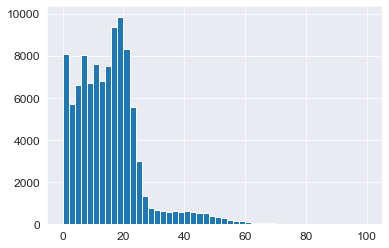

In [23]:
y = df["percentage_time_busy"]
y.hist(bins=50)
plt.show()

In [24]:
df["percentage_time_busy"].describe()

count    101916.000000
mean         14.500108
std          10.456826
min           0.000000
25%           7.000000
50%          14.000000
75%          20.000000
max         100.000000
Name: percentage_time_busy, dtype: float64

# 4. Neue Zeitvariablen rechnen

In [25]:
df.head()

,cars_per_hour,percentage_time_busy,avg_speed,weekday,hour,year,wind_speed,temperature,rain
date,,,,,,,,,
2019-01-01 01:00:00,24.0,10.0,0.0,1.0,1.00,2019.0,0.6800,2.600,0.0
2019-01-01 01:15:00,22.0,5.0,0.0,1.0,1.25,2019.0,0.6825,2.575,0.0
2019-01-01 01:30:00,23.0,2.0,0.0,1.0,1.50,2019.0,0.6850,2.550,0.0
2019-01-01 01:45:00,24.0,2.0,0.0,1.0,1.75,2019.0,0.6875,2.525,0.0
2019-01-01 02:00:00,22.0,10.0,0.0,1.0,2.00,2019.0,0.6900,2.500,0.0


In [26]:
df["month"] = df.index.month
df["bank_holiday"] = df.index.copy().isin(bank_holidays)
df["state_of_alarm"] = (df.index >= "2020-03-14") & (df.index <= "2020-06-21")
df["working_day"] =  (df["weekday"] <= 4) & (~df["bank_holiday"])

df.head()

,cars_per_hour,percentage_time_busy,avg_speed,weekday,hour,year,wind_speed,temperature,rain,month,bank_holiday,state_of_alarm,working_day
date,,,,,,,,,,,,,
2019-01-01 01:00:00,24.0,10.0,0.0,1.0,1.00,2019.0,0.6800,2.600,0.0,1,False,False,True
2019-01-01 01:15:00,22.0,5.0,0.0,1.0,1.25,2019.0,0.6825,2.575,0.0,1,False,False,True
2019-01-01 01:30:00,23.0,2.0,0.0,1.0,1.50,2019.0,0.6850,2.550,0.0,1,False,False,True
2019-01-01 01:45:00,24.0,2.0,0.0,1.0,1.75,2019.0,0.6875,2.525,0.0,1,False,False,True
2019-01-01 02:00:00,22.0,10.0,0.0,1.0,2.00,2019.0,0.6900,2.500,0.0,1,False,False,True


In [27]:
df.loc["2020-03-15"]

,cars_per_hour,percentage_time_busy,avg_speed,weekday,hour,year,wind_speed,temperature,rain,month,bank_holiday,state_of_alarm,working_day
date,,,,,,,,,,,,,
2020-03-15 00:00:00,41.0,9.0,0.0,6.0,0.00,2020.0,0.710000,14.600000,0.0,3,False,True,False
2020-03-15 00:15:00,44.0,8.0,0.0,6.0,0.25,2020.0,0.692500,14.275000,0.0,3,False,True,False
2020-03-15 00:30:00,39.0,8.0,0.0,6.0,0.50,2020.0,0.675000,13.950000,0.0,3,False,True,False
2020-03-15 00:45:00,31.0,9.0,0.0,6.0,0.75,2020.0,0.657500,13.625000,0.0,3,False,True,False
2020-03-15 01:00:00,25.0,4.0,0.0,6.0,1.00,2020.0,0.640000,13.300000,0.0,3,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-15 19:30:00,48.0,8.0,0.0,6.0,19.50,2020.0,1.490000,16.050000,0.0,3,False,True,False
2020-03-15 19:45:00,35.0,6.0,0.0,6.0,19.75,2020.0,1.445000,15.175000,0.0,3,False,True,False
2020-03-15 20:00:00,88.0,18.0,0.0,6.0,20.00,2020.0,1.400000,14.300000,0.0,3,False,True,False


**Unabhängige Variablen**

In [28]:
X = df.drop(["cars_per_hour", "percentage_time_busy", "avg_speed"], axis="columns")
X = X.reset_index(drop=True)
X

,weekday,hour,year,wind_speed,temperature,rain,month,bank_holiday,state_of_alarm,working_day
0,1.0,1.00,2019.0,0.6800,2.600,0.0,1,False,False,True
1,1.0,1.25,2019.0,0.6825,2.575,0.0,1,False,False,True
2,1.0,1.50,2019.0,0.6850,2.550,0.0,1,False,False,True
3,1.0,1.75,2019.0,0.6875,2.525,0.0,1,False,False,True
4,1.0,2.00,2019.0,0.6900,2.500,0.0,1,False,False,True
...,...,...,...,...,...,...,...,...,...,...
101911,4.0,11.25,2021.0,0.7050,9.450,0.0,12,False,False,True
101912,4.0,11.50,2021.0,0.7800,10.300,0.0,12,False,False,True
101913,4.0,11.75,2021.0,0.8550,11.150,0.0,12,False,False,True
101914,4.0,12.00,2021.0,0.9300,12.000,0.0,12,False,False,True


**Wind Geschwindigkeit**

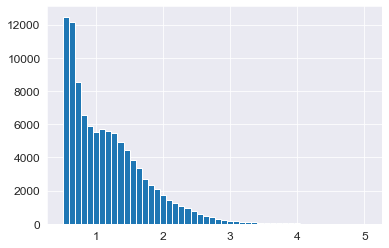

In [29]:
X["wind_speed"].hist(bins=50)
plt.show()

**Niederschlag**

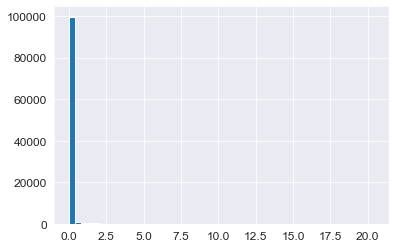

In [30]:
X["rain"].hist(bins=50)
plt.show()

In [31]:
X.loc[X["rain"] == 0, "rain_category"] = "no_rain"
X.loc[(X["rain"] > 0) & (X["rain"] < 2.5), "rain_category"] = "light_rain"
X.loc[(X["rain"] >= 2.5) & (X["rain"] < 7.6), "rain_category"] = "moderate_rain"
X.loc[X["rain"] >= 7.6, "rain_category"] = "heavy_rain"

rain_categories = ["no_rain", "light_rain", "moderate_rain", "heavy_rain"]

del X["rain"]

X["rain_category"].value_counts()

no_rain          96503
light_rain        5027
moderate_rain      336
heavy_rain          50
Name: rain_category, dtype: int64

In [32]:
X.head()

,weekday,hour,year,wind_speed,temperature,month,bank_holiday,state_of_alarm,working_day,rain_category
0,1.0,1.00,2019.0,0.6800,2.600,1,False,False,True,no_rain
1,1.0,1.25,2019.0,0.6825,2.575,1,False,False,True,no_rain
2,1.0,1.50,2019.0,0.6850,2.550,1,False,False,True,no_rain
3,1.0,1.75,2019.0,0.6875,2.525,1,False,False,True,no_rain
4,1.0,2.00,2019.0,0.6900,2.500,1,False,False,True,no_rain


**Die anderen Variablen sind gut ausgeglichen**

In [33]:
X["weekday"].value_counts()

4.0    14647
2.0    14646
1.0    14641
3.0    14633
0.0    14499
6.0    14433
5.0    14417
Name: weekday, dtype: int64

# 5. Zeitbasierte Kreuzvalidierung

### Normale Kreuzvalidierung

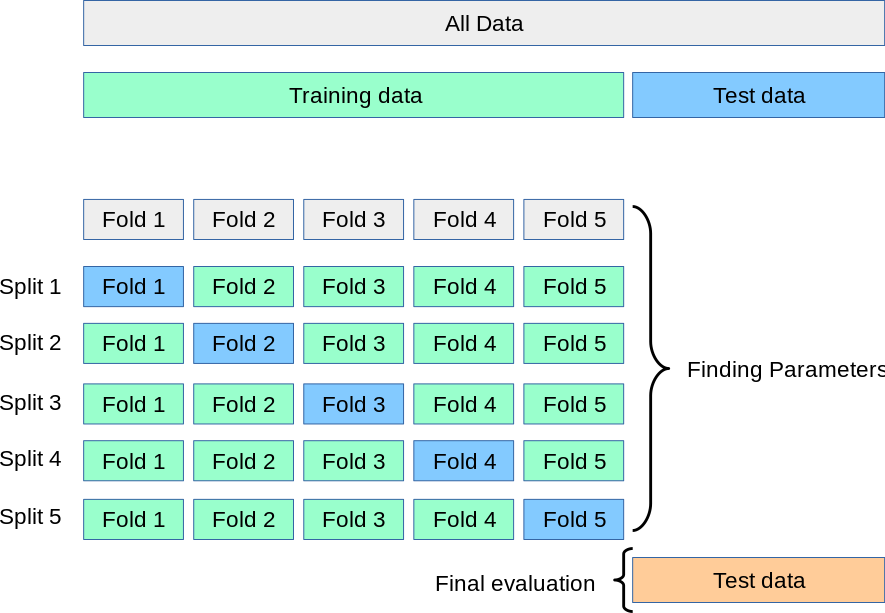

In [34]:
Image(f"{project_path}/figures/data-kolloquium/grid_search_cross_validation.png")

### Zeitbasierte Kreuzvalidierung

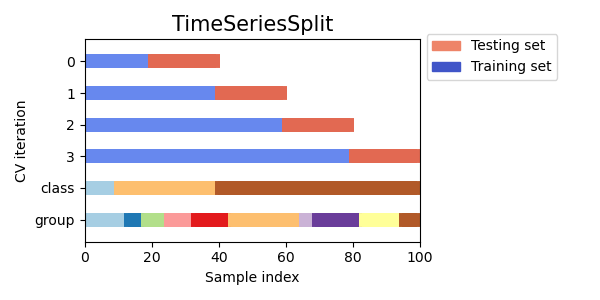

In [35]:
Image(f"{project_path}/figures/data-kolloquium/time-cv.png")

In [36]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(
    n_splits=5,
)

In [37]:
all_splits = list(ts_cv.split(X, y))
train_last, valid_last = all_splits[-2]

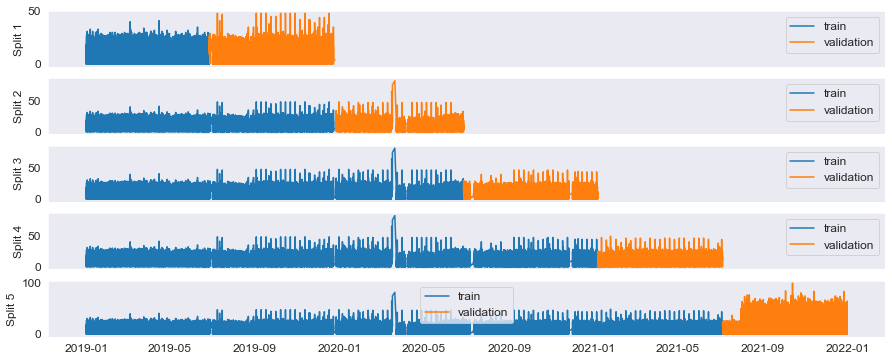

In [38]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 6), sharex=True)
for i, (train, valid) in enumerate(all_splits):
    ax[i].plot(df.iloc[train]['percentage_time_busy'], label="train")
    ax[i].plot(df.iloc[valid]['percentage_time_busy'], label="validation")
    ax[i].set_ylabel(f"Split {i+1}")
    ax[i].legend()
plt.show()

# 6. Gradient Boosting

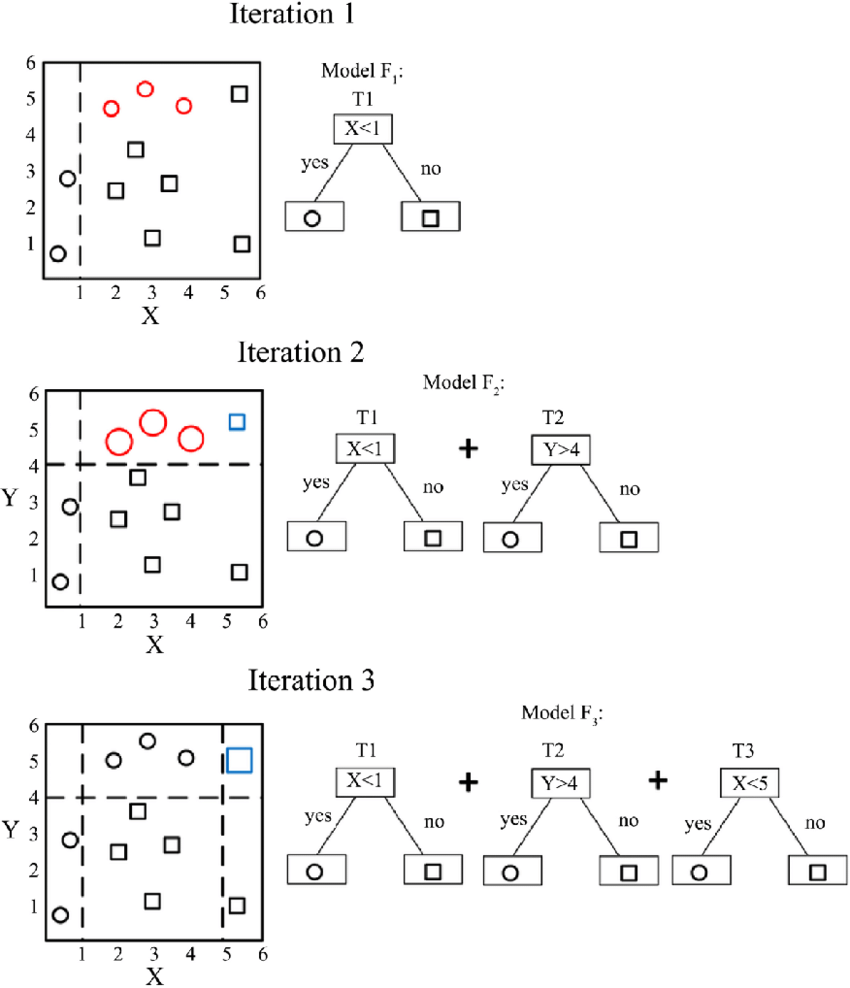

In [39]:
Image(f"{project_path}/figures/data-kolloquium/gradient-boosting.png")

In [40]:
X.head()

,weekday,hour,year,wind_speed,temperature,month,bank_holiday,state_of_alarm,working_day,rain_category
0,1.0,1.00,2019.0,0.6800,2.600,1,False,False,True,no_rain
1,1.0,1.25,2019.0,0.6825,2.575,1,False,False,True,no_rain
2,1.0,1.50,2019.0,0.6850,2.550,1,False,False,True,no_rain
3,1.0,1.75,2019.0,0.6875,2.525,1,False,False,True,no_rain
4,1.0,2.00,2019.0,0.6900,2.500,1,False,False,True,no_rain


In [41]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate

categorical_columns = [
    "bank_holiday",
    "state_of_alarm",
    "working_day",
    "rain_category"
]

categories = [
    [False, True],
    [False, True],
    [False, True],
    rain_categories
]

ordinal_encoder = OrdinalEncoder(categories=categories)

transformer = ColumnTransformer(
    transformers=[
        ("categorical", ordinal_encoder, categorical_columns)
    ],
    remainder="passthrough"
)

x_t = transformer.fit_transform(X)
x_t = pd.DataFrame(x_t, columns=categorical_columns + [c for c in X.columns if c not in categorical_columns])
x_t[X.columns].head()

,weekday,hour,year,wind_speed,temperature,month,bank_holiday,state_of_alarm,working_day,rain_category
0,1.0,1.00,2019.0,0.6800,2.600,1.0,0.0,0.0,1.0,0.0
1,1.0,1.25,2019.0,0.6825,2.575,1.0,0.0,0.0,1.0,0.0
2,1.0,1.50,2019.0,0.6850,2.550,1.0,0.0,0.0,1.0,0.0
3,1.0,1.75,2019.0,0.6875,2.525,1.0,0.0,0.0,1.0,0.0
4,1.0,2.00,2019.0,0.6900,2.500,1.0,0.0,0.0,1.0,0.0


In [42]:
X.head()

,weekday,hour,year,wind_speed,temperature,month,bank_holiday,state_of_alarm,working_day,rain_category
0,1.0,1.00,2019.0,0.6800,2.600,1,False,False,True,no_rain
1,1.0,1.25,2019.0,0.6825,2.575,1,False,False,True,no_rain
2,1.0,1.50,2019.0,0.6850,2.550,1,False,False,True,no_rain
3,1.0,1.75,2019.0,0.6875,2.525,1,False,False,True,no_rain
4,1.0,2.00,2019.0,0.6900,2.500,1,False,False,True,no_rain


In [43]:
from sklearn import set_config
set_config(display="diagram")

In [44]:
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('categorical',
                                 OrdinalEncoder(categories=[[False, True],
                                                            [False, True],
                                                            [False, True],
                                                            ['no_rain',
                                                             'light_rain',
                                                             'moderate_rain',
                                                             'heavy_rain']]),
                                 ['bank_holiday', 'state_of_alarm',
                                  'working_day', 'rain_category'])])

In [45]:
gbrt_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", ordinal_encoder, categorical_columns),
        ],
        remainder="passthrough",
    ),
    HistGradientBoostingRegressor(
        categorical_features=range(4),
    ),
)

gbrt_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OrdinalEncoder(categories=[[False,
                                                                              True],
                                                                             [False,
                                                                              True],
                                                                             [False,
                                                                              True],
                                                                             ['no_rain',
                                                                              'light_rain',
                                                                              'moderate_rain',
                                                                              'heavy_rain']]),
                                                  ['bank_holiday',
                                                   'state_of_alarm',
                                                   'working_day',
                                                   'rain_category'])])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(categorical_features=range(0, 4)))])

In [46]:
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

evaluate(gbrt_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     5.011 +/- 3.411
Root Mean Squared Error: 7.094 +/- 4.895


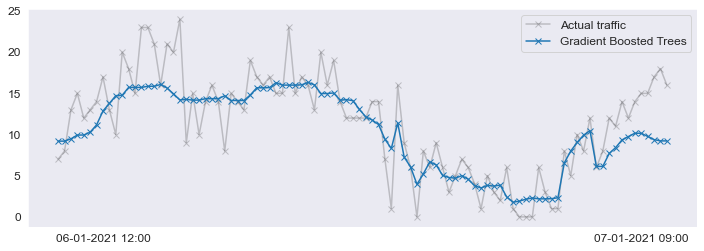

In [47]:
gbrt_pipeline.fit(X.iloc[train_last], y.iloc[train_last])
gbrt_predictions = gbrt_pipeline.predict(X.iloc[valid_last])
from matplotlib.dates import DateFormatter

first_hours = slice(0, 4*24) # 24 hours
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(
    y.iloc[valid_last].iloc[first_hours],
    "x-",
    alpha=0.2,
    label="Actual traffic",
    color="black",
)
ax.plot(
    y.iloc[valid_last].iloc[first_hours].index,
    gbrt_predictions[first_hours],
    "x-",
    label="Gradient Boosted Trees",
)

ax.set_xticks([ax.get_xticks()[0], ax.get_xticks()[-1]])
date_form = DateFormatter("%d-%m-%Y %H:%M")
ax.xaxis.set_major_formatter(date_form)

_ = ax.legend()

# 7. Naive linear regression

In [48]:
X.head()

,weekday,hour,year,wind_speed,temperature,month,bank_holiday,state_of_alarm,working_day,rain_category
0,1.0,1.00,2019.0,0.6800,2.600,1,False,False,True,no_rain
1,1.0,1.25,2019.0,0.6825,2.575,1,False,False,True,no_rain
2,1.0,1.50,2019.0,0.6850,2.550,1,False,False,True,no_rain
3,1.0,1.75,2019.0,0.6875,2.525,1,False,False,True,no_rain
4,1.0,2.00,2019.0,0.6900,2.500,1,False,False,True,no_rain


In [49]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import RidgeCV, LinearRegression
import numpy as np

In [50]:
one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
ordinal_encoder = OrdinalEncoder(categories=categories[:3])

transformer = ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, ["rain_category"]),
            ("binary", ordinal_encoder, categorical_columns[:3])
        ],
        remainder=MinMaxScaler(),
    )

transformer

ColumnTransformer(remainder=MinMaxScaler(),
                  transformers=[('categorical',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['rain_category']),
                                ('binary',
                                 OrdinalEncoder(categories=[[False, True],
                                                            [False, True],
                                                            [False, True]]),
                                 ['bank_holiday', 'state_of_alarm',
                                  'working_day'])])

In [51]:
x_t = transformer.fit_transform(X)
column_names = transformer.transformers_[0][1].categories_[0].tolist() + categorical_columns[:3] + [c for c in X.columns if c not in categorical_columns]
x_t = pd.DataFrame(x_t, columns=column_names)
x_t[:10]

,heavy_rain,light_rain,moderate_rain,no_rain,bank_holiday,state_of_alarm,working_day,weekday,hour,year,wind_speed,temperature,month
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.166667,0.042105,0.0,0.039648,0.210421,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.166667,0.052632,0.0,0.040198,0.209920,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.166667,0.063158,0.0,0.040749,0.209419,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.166667,0.073684,0.0,0.041300,0.208918,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.166667,0.084211,0.0,0.041850,0.208417,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.166667,0.094737,0.0,0.042401,0.204409,0.0
6,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.166667,0.105263,0.0,0.042952,0.200401,0.0
7,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.166667,0.115789,0.0,0.043502,0.196393,0.0
8,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.166667,0.126316,0.0,0.044053,0.192385,0.0
9,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.166667,0.136842,0.0,0.044053,0.189379,0.0


In [52]:
alphas = np.logspace(-6, 6, 25)

naive_linear_pipeline = make_pipeline(
    transformer,
    RidgeCV(alphas=alphas),
)

evaluate(naive_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     6.771 +/- 3.638
Root Mean Squared Error: 8.765 +/- 5.054


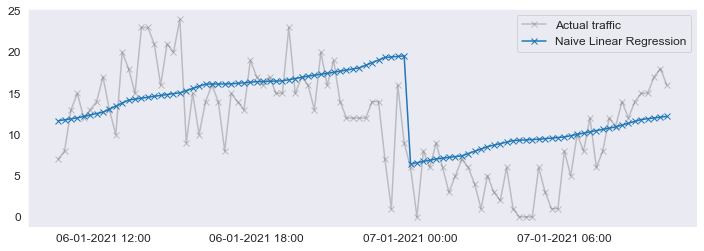

In [53]:
naive_linear_pipeline.fit(X.iloc[train_last], y.iloc[train_last])
naive_linear_predictions = naive_linear_pipeline.predict(X.iloc[valid_last])

first_hours = slice(0, 4*24) # 24 hours
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(
    y.iloc[valid_last].iloc[first_hours],
    "x-",
    alpha=0.2,
    label="Actual traffic",
    color="black",
)
ax.plot(
    y.iloc[valid_last].iloc[first_hours].index,
    naive_linear_predictions[first_hours],
    "x-",
    label="Naive Linear Regression",
)

ax.set_xticks(ax.get_xticks()[::2])
ax.xaxis.set_major_formatter(date_form)

_ = ax.legend()

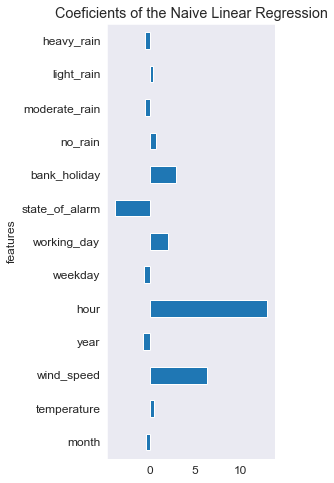

In [54]:
fig, ax = plt.subplots(figsize=(3, 8), sharey=True)
coefs = naive_linear_pipeline[-1].coef_
pd.DataFrame(zip(coefs, column_names)).iloc[::-1].rename(columns={0: "importances", 1: "features"}).plot.barh(
    x=1, ax=ax, legend=False)
ax.set_title("Coeficients of the Naive Linear Regression")
plt.show()

# 8. Zeitschritte als Kategorien (One-hot)

In [55]:
df.iloc[:200][["hour", "weekday", "month", "year"]]

,hour,weekday,month,year
date,,,,
2019-01-01 01:00:00,1.00,1.0,1,2019.0
2019-01-01 01:15:00,1.25,1.0,1,2019.0
2019-01-01 01:30:00,1.50,1.0,1,2019.0
2019-01-01 01:45:00,1.75,1.0,1,2019.0
2019-01-01 02:00:00,2.00,1.0,1,2019.0
...,...,...,...,...
2019-01-03 01:45:00,1.75,3.0,1,2019.0
2019-01-03 02:00:00,2.00,3.0,1,2019.0
2019-01-03 02:15:00,2.25,3.0,1,2019.0


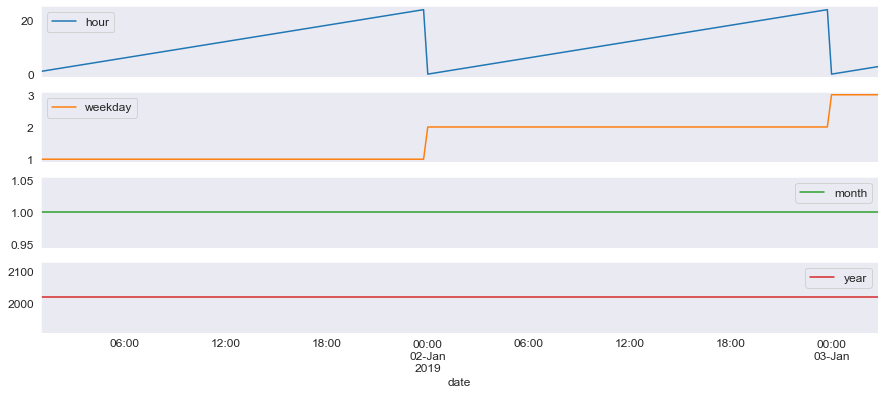

In [56]:
temporal_variables = ["hour", "weekday", "month", "year"]

fig, axs = plt.subplots(nrows=4, figsize=(15, 6), sharex=True)
df.iloc[:200][temporal_variables].plot(subplots=True, ax=axs)
plt.show()

In [57]:
from sklearn.preprocessing import FunctionTransformer
one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

In [58]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
years = [2019, 2020, 2021]

temporal_one_hot_encoder = ColumnTransformer(transformers=[
    ("hour_one_hot", make_pipeline(FunctionTransformer(np.floor), one_hot_encoder), ["hour"]),
    ("temporal_one_hot", one_hot_encoder, ["weekday", "month", "year"])
])
x_t = temporal_one_hot_encoder.fit_transform(X[temporal_variables])
temporal_one_hot_columns = [f"hour_{i}" for i in range(24)] + weekdays + months + years
pd.DataFrame(x_t, columns=temporal_one_hot_columns).head()

,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,...,Jun,Jul,Aug,Sep,Oct,Nov,Dec,2019,2020,2021
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [59]:
one_hot_linear_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("temporal_one_hot", temporal_one_hot_encoder, temporal_variables),
            ("rain_one_hot", one_hot_encoder, ["rain_category"]),
            ("binary", ordinal_encoder, categorical_columns[:3]),
        ],
        remainder=MinMaxScaler(),
    ),
    RidgeCV(alphas=alphas),
)

one_hot_linear_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=MinMaxScaler(),
                                   transformers=[('temporal_one_hot',
                                                  ColumnTransformer(transformers=[('hour_one_hot',
                                                                                   Pipeline(steps=[('functiontransformer',
                                                                                                    FunctionTransformer(func=<ufunc 'floor'>)),
                                                                                                   ('onehotencoder',
                                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                                  sparse=False))]),
                                                                                   ['hour']),
                                                                                  ('temporal_one_hot',
                                                                                   OneHo...
                 RidgeCV(alphas=array([1.00000000e-06, 3.16227766e-06, 1.00000000e-05, 3.16227766e-05,
       1.00000000e-04, 3.16227766e-04, 1.00000000e-03, 3.16227766e-03,
       1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00, 3.16227766e+00, 1.00000000e+01, 3.16227766e+01,
       1.00000000e+02, 3.16227766e+02, 1.00000000e+03, 3.16227766e+03,
       1.00000000e+04, 3.16227766e+04, 1.00000000e+05, 3.16227766e+05,
       1.00000000e+06])))])

In [60]:
evaluate(one_hot_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     5.380 +/- 3.564
Root Mean Squared Error: 7.370 +/- 5.035


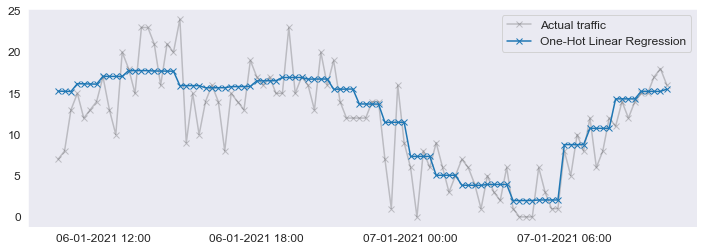

In [61]:
one_hot_linear_pipeline.fit(X.iloc[train_last], y.iloc[train_last])
one_hot_linear_predictions = one_hot_linear_pipeline.predict(X.iloc[valid_last])

first_hours = slice(0, 4*24) # 24 hours
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(
    y.iloc[valid_last].iloc[first_hours],
    "x-",
    alpha=0.2,
    label="Actual traffic",
    color="black",
)
ax.plot(
    y.iloc[valid_last].iloc[first_hours].index,
    one_hot_linear_predictions[first_hours],
    "x-",
    label="One-Hot Linear Regression",
)

ax.set_xticks(ax.get_xticks()[::2])
ax.xaxis.set_major_formatter(date_form)

_ = ax.legend()

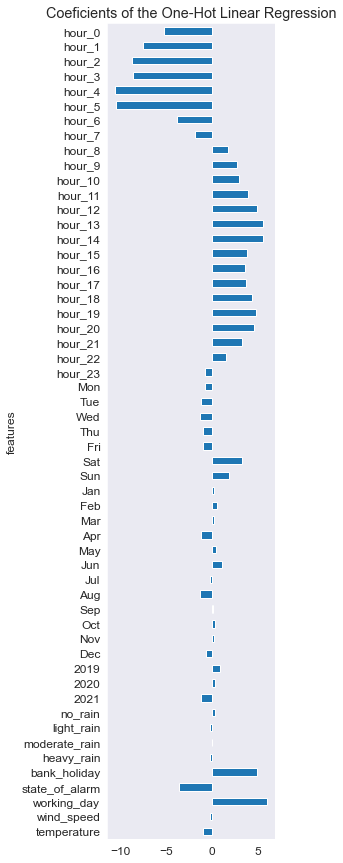

In [62]:
fig, ax = plt.subplots(figsize=(3, 15), sharey=True)
coefs = one_hot_linear_pipeline[-1].coef_
column_names = temporal_one_hot_columns + rain_categories + categorical_columns[:3] + ["wind_speed", "temperature"]
pd.DataFrame(zip(coefs, column_names)).iloc[::-1].rename(columns={0: "importances", 1: "features"}).plot.barh(
    x=1, ax=ax, legend=False)
ax.set_title("Coeficients of the One-Hot Linear Regression")
plt.show()

# 9. Trigonometric Features (Fourier series)

In [63]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

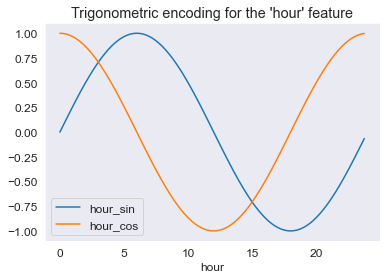

In [64]:
hour_df = pd.DataFrame(
    np.arange(0, 24, step=0.25).reshape(-1, 1),
    columns=["hour"],
)

hour_df["hour_sin"] = sin_transformer(24).fit_transform(hour_df)["hour"]
hour_df["hour_cos"] = cos_transformer(24).fit_transform(hour_df)["hour"]
hour_df.plot(x="hour")
_ = plt.title("Trigonometric encoding for the 'hour' feature")

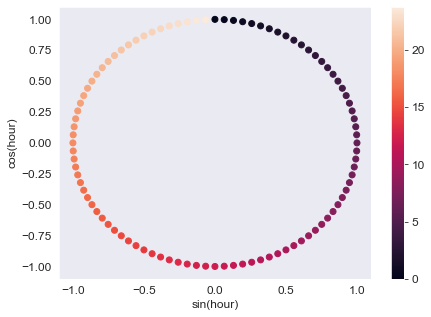

In [65]:
fig, ax = plt.subplots(figsize=(7, 5))
sp = ax.scatter(hour_df["hour_sin"], hour_df["hour_cos"], c=hour_df["hour"])
ax.set(
    xlabel="sin(hour)",
    ylabel="cos(hour)",
)
_ = fig.colorbar(sp)

In [66]:
temporal_transformer = ColumnTransformer(transformers=[
    ("hour_sin", sin_transformer(24), ["hour"]),
    ("hour_cos", cos_transformer(24), ["hour"]),
    ("weekday_sin", sin_transformer(7), ["weekday"]),
    ("weekday_cos", cos_transformer(7), ["weekday"]),
    ("month_sin", sin_transformer(12), ["month"]),
    ("month_cos", cos_transformer(12), ["month"]),
    ("year_one_hot", one_hot_encoder, ["year"])
])

x_t = temporal_transformer.fit_transform(X)
temporal_columns = ["hour_sin", "hour_cos", "weekday_sin", "weekday_cos", "month_sin", "month_cos", "2019", "2020", "2021"]
x_t = pd.DataFrame(x_t, columns=temporal_columns)
x_t.head(10)

,hour_sin,hour_cos,weekday_sin,weekday_cos,month_sin,month_cos,2019,2020,2021
0,0.258819,0.965926,0.781831,0.62349,0.5,0.866025,1.0,0.0,0.0
1,0.321439,0.946930,0.781831,0.62349,0.5,0.866025,1.0,0.0,0.0
2,0.382683,0.923880,0.781831,0.62349,0.5,0.866025,1.0,0.0,0.0
3,0.442289,0.896873,0.781831,0.62349,0.5,0.866025,1.0,0.0,0.0
4,0.500000,0.866025,0.781831,0.62349,0.5,0.866025,1.0,0.0,0.0
5,0.555570,0.831470,0.781831,0.62349,0.5,0.866025,1.0,0.0,0.0
6,0.608761,0.793353,0.781831,0.62349,0.5,0.866025,1.0,0.0,0.0
7,0.659346,0.751840,0.781831,0.62349,0.5,0.866025,1.0,0.0,0.0
8,0.707107,0.707107,0.781831,0.62349,0.5,0.866025,1.0,0.0,0.0
9,0.751840,0.659346,0.781831,0.62349,0.5,0.866025,1.0,0.0,0.0


In [67]:
temporal_transformer

ColumnTransformer(transformers=[('hour_sin',
                                 FunctionTransformer(func=<function sin_transformer.<locals>.<lambda> at 0x0000018067E6E430>),
                                 ['hour']),
                                ('hour_cos',
                                 FunctionTransformer(func=<function cos_transformer.<locals>.<lambda> at 0x0000018067E6E3A0>),
                                 ['hour']),
                                ('weekday_sin',
                                 FunctionTransformer(func=<function sin_transformer.<locals>.<lambda> at 0x00000180...
                                 FunctionTransformer(func=<function cos_transformer.<locals>.<lambda> at 0x0000018067E6E0D0>),
                                 ['weekday']),
                                ('month_sin',
                                 FunctionTransformer(func=<function sin_transformer.<locals>.<lambda> at 0x0000018067E6E310>),
                                 ['month']),
                                ('month_cos',
                                 FunctionTransformer(func=<function cos_transformer.<locals>.<lambda> at 0x0000018067E6E820>),
                                 ['month']),
                                ('year_one_hot',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['year'])])

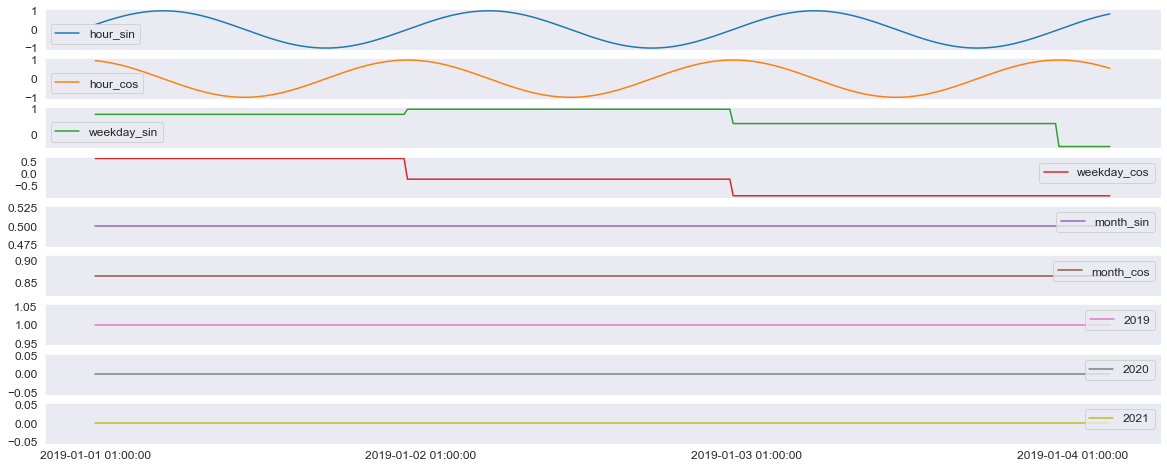

In [68]:
ax = x_t.iloc[:300].plot(subplots=True, sharex=True, figsize=(20, 8), xticks=x_t.iloc[:300].index[::4*24])
ax[-1].set_xticklabels(y.iloc[:300].index[::4*24])
#ax[-1].xaxis.set_major_formatter(date_form)
plt.show()

In [69]:
cyclic_cossin_linear_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("temporal", temporal_transformer, temporal_variables),
            ("rain_one_hot", one_hot_encoder, ["rain_category"]),
            ("binary", ordinal_encoder, categorical_columns[:3]),
        ],
        remainder=MinMaxScaler(),
    ),
    RidgeCV(alphas=alphas),
)

cyclic_cossin_linear_pipeline.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=MinMaxScaler(),
                                   transformers=[('temporal',
                                                  ColumnTransformer(transformers=[('hour_sin',
                                                                                   FunctionTransformer(func=<function sin_transformer.<locals>.<lambda> at 0x0000018067E6E430>),
                                                                                   ['hour']),
                                                                                  ('hour_cos',
                                                                                   FunctionTransformer(func=<function cos_transformer.<locals>.<lambda> at 0x0000018067E6E3A0>...
                 RidgeCV(alphas=array([1.00000000e-06, 3.16227766e-06, 1.00000000e-05, 3.16227766e-05,
       1.00000000e-04, 3.16227766e-04, 1.00000000e-03, 3.16227766e-03,
       1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00, 3.16227766e+00, 1.00000000e+01, 3.16227766e+01,
       1.00000000e+02, 3.16227766e+02, 1.00000000e+03, 3.16227766e+03,
       1.00000000e+04, 3.16227766e+04, 1.00000000e+05, 3.16227766e+05,
       1.00000000e+06])))])

In [70]:
evaluate(cyclic_cossin_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     5.946 +/- 3.543
Root Mean Squared Error: 7.934 +/- 4.943


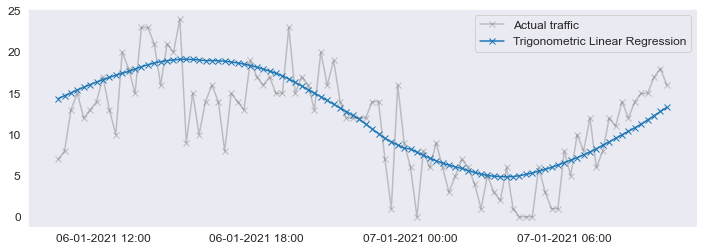

In [71]:
cyclic_cossin_linear_pipeline.fit(X.iloc[train_last], y.iloc[train_last])
cyclic_cossin_linear_predictions = cyclic_cossin_linear_pipeline.predict(X.iloc[valid_last])

first_hours = slice(0, 4*24) # 24 hours
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(
    y.iloc[valid_last].iloc[first_hours],
    "x-",
    alpha=0.2,
    label="Actual traffic",
    color="black",
)
ax.plot(
    y.iloc[valid_last].iloc[first_hours].index,
    cyclic_cossin_linear_predictions[first_hours],
    "x-",
    label="Trigonometric Linear Regression",
)

ax.set_xticks(ax.get_xticks()[::2])
ax.xaxis.set_major_formatter(date_form)

_ = ax.legend()

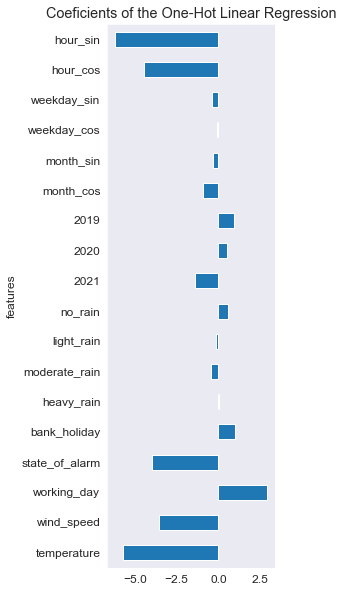

In [72]:
fig, ax = plt.subplots(figsize=(3, 10), sharey=True)
coefs = cyclic_cossin_linear_pipeline[-1].coef_
column_names = temporal_columns + rain_categories + categorical_columns[:3] + ["wind_speed", "temperature"]
pd.DataFrame(zip(coefs, column_names)).iloc[::-1].rename(columns={0: "importances", 1: "features"}).plot.barh(
    x=1, ax=ax, legend=False)
ax.set_title("Coeficients of the One-Hot Linear Regression")
plt.show()

# 10. Periodic spline features

In [73]:
from sklearn.preprocessing import SplineTransformer

def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

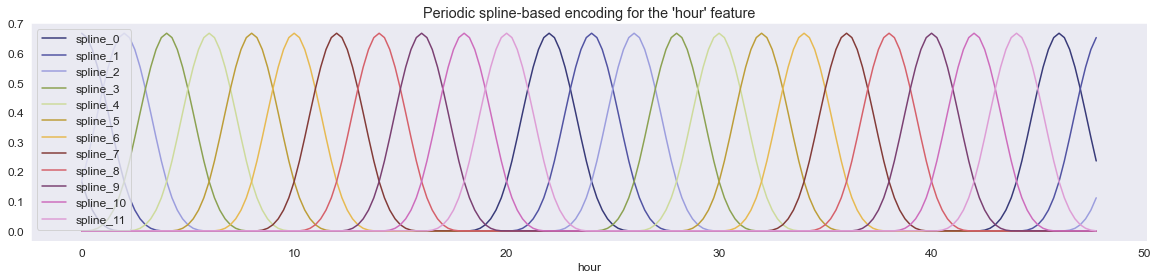

In [74]:
hour_df = pd.DataFrame(
    np.arange(0, 48, 0.25).reshape(-1, 1),
    columns=["hour"],
)
splines = periodic_spline_transformer(24, n_splines=12).fit_transform(hour_df)
splines_df = pd.DataFrame(
    splines,
    columns=[f"spline_{i}" for i in range(splines.shape[1])],
)
pd.concat([hour_df, splines_df], axis="columns").plot(x="hour", cmap=plt.cm.tab20b, figsize=(20, 4))
_ = plt.title("Periodic spline-based encoding for the 'hour' feature")

In [75]:
spline_temporal_transformer = ColumnTransformer(
    transformers=[
        ("cyclic_month", periodic_spline_transformer(12, n_splines=6), ["month"]),
        ("cyclic_weekday", periodic_spline_transformer(7, n_splines=3), ["weekday"]),
        ("cyclic_hour", periodic_spline_transformer(24, n_splines=12), ["hour"]),
    ]
)

cyclic_spline_linear_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("spline_temporal", spline_temporal_transformer, temporal_variables[:-1]),
            ("year_one_hot", one_hot_encoder, ["year"]),
            ("rain_one_hot", one_hot_encoder, ["rain_category"]),
            ("binary", ordinal_encoder, categorical_columns[:3]),
        ],
        remainder=MinMaxScaler(),
    ),
    RidgeCV(alphas=alphas),
)

cyclic_spline_linear_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=MinMaxScaler(),
                                   transformers=[('spline_temporal',
                                                  ColumnTransformer(transformers=[('cyclic_month',
                                                                                   SplineTransformer(extrapolation='periodic',
                                                                                                     knots=array([[ 0.],
       [ 2.],
       [ 4.],
       [ 6.],
       [ 8.],
       [10.],
       [12.]]),
                                                                                                     n_knots=7),
                                                                                   ['month']),
                                                                                  ('cyclic_weekday',
                                                                                   SplineTransformer(extrapolation='periodic',
                                                                                                     knots=array...
                 RidgeCV(alphas=array([1.00000000e-06, 3.16227766e-06, 1.00000000e-05, 3.16227766e-05,
       1.00000000e-04, 3.16227766e-04, 1.00000000e-03, 3.16227766e-03,
       1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00, 3.16227766e+00, 1.00000000e+01, 3.16227766e+01,
       1.00000000e+02, 3.16227766e+02, 1.00000000e+03, 3.16227766e+03,
       1.00000000e+04, 3.16227766e+04, 1.00000000e+05, 3.16227766e+05,
       1.00000000e+06])))])

In [76]:
evaluate(cyclic_spline_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     7.400 +/- 4.493
Root Mean Squared Error: 9.615 +/- 5.740


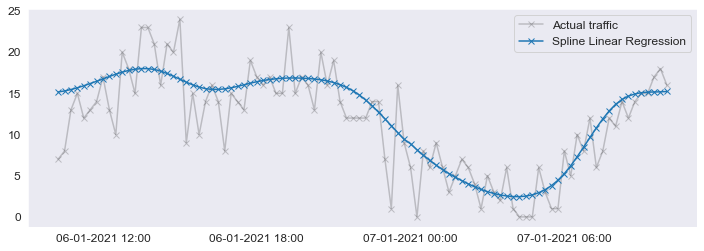

In [77]:
cyclic_spline_linear_pipeline.fit(X.iloc[train_last], y.iloc[train_last])
cyclic_spline_linear_predictions = cyclic_spline_linear_pipeline.predict(X.iloc[valid_last])

first_hours = slice(0, 4*24) # 24 hours
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(
    y.iloc[valid_last].iloc[first_hours],
    "x-",
    alpha=0.2,
    label="Actual traffic",
    color="black",
)
ax.plot(
    y.iloc[valid_last].iloc[first_hours].index,
    cyclic_spline_linear_predictions[first_hours],
    "x-",
    label="Spline Linear Regression",
)

ax.set_xticks(ax.get_xticks()[::2])
ax.xaxis.set_major_formatter(date_form)

_ = ax.legend()

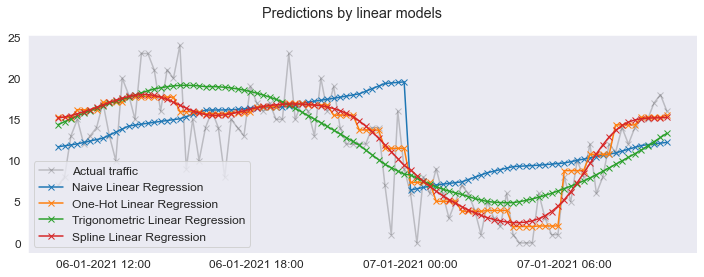

In [78]:
first_hours = slice(0, 4*24) # 24 hours
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(
    y.iloc[valid_last].iloc[first_hours],
    "x-",
    alpha=0.2,
    label="Actual traffic",
    color="black",
)

fig.suptitle("Predictions by linear models")
# ax.plot(
#     y.iloc[valid_last].iloc[first_hours].index,
#     gbrt_predictions[first_hours],
#     "x-",
#     label="Gradient Boosted Trees",
# )
ax.plot(
    y.iloc[valid_last].iloc[first_hours].index,
    naive_linear_predictions[first_hours],
    "x-",
    label="Naive Linear Regression",
)
ax.plot(
    y.iloc[valid_last].iloc[first_hours].index,
    one_hot_linear_predictions[first_hours],
    "x-",
    label="One-Hot Linear Regression",
)
ax.plot(
    y.iloc[valid_last].iloc[first_hours].index,
    cyclic_cossin_linear_predictions[first_hours],
    "x-",
    label="Trigonometric Linear Regression",
)
ax.plot(
    y.iloc[valid_last].iloc[first_hours].index,
    cyclic_spline_linear_predictions[first_hours],
    "x-",
    label="Spline Linear Regression",
)

ax.set_xticks(ax.get_xticks()[::2])
ax.xaxis.set_major_formatter(date_form)

_ = ax.legend()

In [79]:
evaluate(gbrt_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     5.070 +/- 3.419
Root Mean Squared Error: 7.174 +/- 4.893


In [80]:
evaluate(naive_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     6.771 +/- 3.638
Root Mean Squared Error: 8.765 +/- 5.054


In [81]:
evaluate(one_hot_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     5.380 +/- 3.564
Root Mean Squared Error: 7.370 +/- 5.035


In [82]:
evaluate(cyclic_cossin_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     5.946 +/- 3.543
Root Mean Squared Error: 7.934 +/- 4.943


In [83]:
evaluate(cyclic_spline_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     7.400 +/- 4.493
Root Mean Squared Error: 9.615 +/- 5.740


# 11. Interaktionen

In [85]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import FeatureUnion


hour_workday_interaction = make_pipeline(
    ColumnTransformer(
        [
            ("hour_one_hot", one_hot_encoder, ["hour"]),
            ("working_day", FunctionTransformer(lambda x: x == "True"), ["working_day"]),
        ]
    ),
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
)

one_hot_interactions_pipeline = make_pipeline(
    FeatureUnion(
        [
            ("marginal", ColumnTransformer(
        transformers=[
            ("temporal_one_hot", temporal_one_hot_encoder, temporal_variables),
            ("rain_one_hot", one_hot_encoder, ["rain_category"]),
            ("binary", ordinal_encoder, categorical_columns[:3]),
        ],
        remainder=MinMaxScaler(),
    )),
            ("interactions", hour_workday_interaction),
        ]
    ),
    RidgeCV(alphas=alphas),
)

one_hot_interactions_pipeline

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('marginal',
                                                 ColumnTransformer(remainder=MinMaxScaler(),
                                                                   transformers=[('temporal_one_hot',
                                                                                  ColumnTransformer(transformers=[('hour_one_hot',
                                                                                                                   Pipeline(steps=[('functiontransformer',
                                                                                                                                    FunctionTransformer(func=<ufunc 'floor'>)),
                                                                                                                                   ('onehotencoder',
                                                                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                                                                  sparse=False))...
                 RidgeCV(alphas=array([1.00000000e-06, 3.16227766e-06, 1.00000000e-05, 3.16227766e-05,
       1.00000000e-04, 3.16227766e-04, 1.00000000e-03, 3.16227766e-03,
       1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00, 3.16227766e+00, 1.00000000e+01, 3.16227766e+01,
       1.00000000e+02, 3.16227766e+02, 1.00000000e+03, 3.16227766e+03,
       1.00000000e+04, 3.16227766e+04, 1.00000000e+05, 3.16227766e+05,
       1.00000000e+06])))])

In [86]:
from sklearn.kernel_approximation import Nystroem

In [94]:
cyclic_spline_poly_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("spline_temporal", spline_temporal_transformer, temporal_variables[:-1]),
            ("year_one_hot", one_hot_encoder, ["year"]),
            ("rain_one_hot", one_hot_encoder, ["rain_category"]),
            ("binary", ordinal_encoder, categorical_columns[:3]),
        ],
        remainder=MinMaxScaler(),
    ),
    Nystroem(kernel="poly", degree=2, n_components=300, random_state=0),
    RidgeCV(alphas=alphas),
)

cyclic_spline_poly_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=MinMaxScaler(),
                                   transformers=[('spline_temporal',
                                                  ColumnTransformer(transformers=[('cyclic_month',
                                                                                   SplineTransformer(extrapolation='periodic',
                                                                                                     knots=array([[ 0.],
       [ 2.],
       [ 4.],
       [ 6.],
       [ 8.],
       [10.],
       [12.]]),
                                                                                                     n_knots=7),
                                                                                   ['month']),
                                                                                  ('cyclic_weekday',
                                                                                   SplineTransformer(extrapolation='periodic',
                                                                                                     knots=array...
                 RidgeCV(alphas=array([1.00000000e-06, 3.16227766e-06, 1.00000000e-05, 3.16227766e-05,
       1.00000000e-04, 3.16227766e-04, 1.00000000e-03, 3.16227766e-03,
       1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00, 3.16227766e+00, 1.00000000e+01, 3.16227766e+01,
       1.00000000e+02, 3.16227766e+02, 1.00000000e+03, 3.16227766e+03,
       1.00000000e+04, 3.16227766e+04, 1.00000000e+05, 3.16227766e+05,
       1.00000000e+06])))])

In [89]:
evaluate(cyclic_spline_poly_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     18.972 +/- 19.931
Root Mean Squared Error: 24.708 +/- 24.746


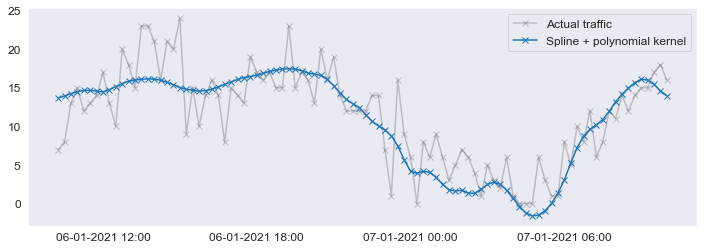

In [100]:
cyclic_spline_poly_pipeline.fit(X.iloc[train_last], y.iloc[train_last])
cyclic_spline_poly_predictions = cyclic_spline_poly_pipeline.predict(X.iloc[valid_last])

first_hours = slice(0, 4*24) # 24 hours
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(
    y.iloc[valid_last].iloc[first_hours],
    "x-",
    alpha=0.2,
    label="Actual traffic",
    color="black",
)

ax.plot(
    y.iloc[valid_last].iloc[first_hours].index,
    cyclic_spline_poly_predictions[first_hours],
    "x-",
    label="Spline + polynomial kernel",
)

ax.set_xticks(ax.get_xticks()[::2])
ax.xaxis.set_major_formatter(date_form)

_ = ax.legend()

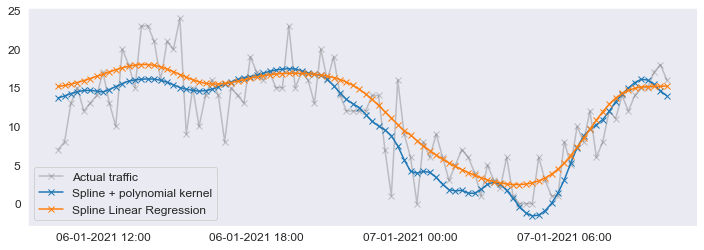

In [101]:
first_hours = slice(0, 4*24) # 24 hours
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(
    y.iloc[valid_last].iloc[first_hours],
    "x-",
    alpha=0.2,
    label="Actual traffic",
    color="black",
)
ax.plot(
    y.iloc[valid_last].iloc[first_hours].index,
    cyclic_spline_poly_predictions[first_hours],
    "x-",
    label="Spline + polynomial kernel",
)

ax.plot(
    y.iloc[valid_last].iloc[first_hours].index,
    cyclic_spline_linear_predictions[first_hours],
    "x-",
    label="Spline Linear Regression",
)

ax.set_xticks(ax.get_xticks()[::2])
ax.xaxis.set_major_formatter(date_form)

_ = ax.legend()

In [90]:
one_hot_poly_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("one_hot_temporal", temporal_one_hot_encoder, temporal_variables),
            ("rain_one_hot", one_hot_encoder, ["rain_category"]),
            ("binary", ordinal_encoder, categorical_columns[:3]),
        ],
        remainder=MinMaxScaler(),
    ),
    Nystroem(kernel="poly", degree=2, n_components=300, random_state=0),
    RidgeCV(alphas=alphas),
)

one_hot_poly_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=MinMaxScaler(),
                                   transformers=[('one_hot_temporal',
                                                  ColumnTransformer(transformers=[('hour_one_hot',
                                                                                   Pipeline(steps=[('functiontransformer',
                                                                                                    FunctionTransformer(func=<ufunc 'floor'>)),
                                                                                                   ('onehotencoder',
                                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                                  sparse=False))]),
                                                                                   ['hour']),
                                                                                  ('temporal_one_hot',
                                                                                   OneHo...
                 RidgeCV(alphas=array([1.00000000e-06, 3.16227766e-06, 1.00000000e-05, 3.16227766e-05,
       1.00000000e-04, 3.16227766e-04, 1.00000000e-03, 3.16227766e-03,
       1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00, 3.16227766e+00, 1.00000000e+01, 3.16227766e+01,
       1.00000000e+02, 3.16227766e+02, 1.00000000e+03, 3.16227766e+03,
       1.00000000e+04, 3.16227766e+04, 1.00000000e+05, 3.16227766e+05,
       1.00000000e+06])))])

In [92]:
evaluate(one_hot_poly_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     5.231 +/- 3.455
Root Mean Squared Error: 7.238 +/- 4.886


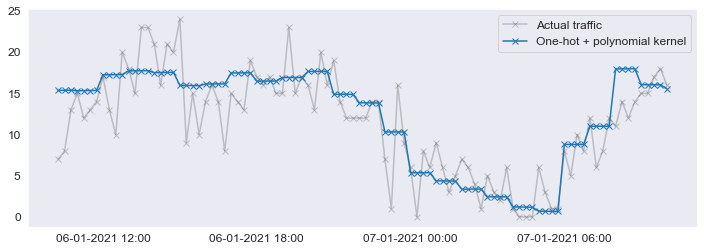

In [103]:
one_hot_poly_pipeline.fit(X.iloc[train_last], y.iloc[train_last])
one_hot_poly_predictions = one_hot_poly_pipeline.predict(X.iloc[valid_last])

first_hours = slice(0, 4*24) # 24 hours
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(
    y.iloc[valid_last].iloc[first_hours],
    "x-",
    alpha=0.2,
    label="Actual traffic",
    color="black",
)

ax.plot(
    y.iloc[valid_last].iloc[first_hours].index,
    one_hot_poly_predictions[first_hours],
    "x-",
    label="One-hot + polynomial kernel",
)

ax.set_xticks(ax.get_xticks()[::2])
ax.xaxis.set_major_formatter(date_form)

_ = ax.legend()

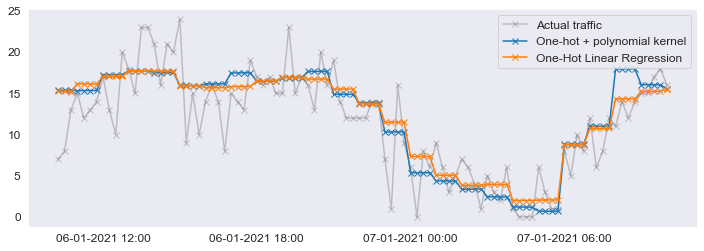

In [104]:
first_hours = slice(0, 4*24) # 24 hours
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(
    y.iloc[valid_last].iloc[first_hours],
    "x-",
    alpha=0.2,
    label="Actual traffic",
    color="black",
)

ax.plot(
    y.iloc[valid_last].iloc[first_hours].index,
    one_hot_poly_predictions[first_hours],
    "x-",
    label="One-hot + polynomial kernel",
)

ax.plot(
    y.iloc[valid_last].iloc[first_hours].index,
    one_hot_linear_predictions[first_hours],
    "x-",
    label="One-Hot Linear Regression",
)


ax.set_xticks(ax.get_xticks()[::2])
ax.xaxis.set_major_formatter(date_form)

_ = ax.legend()

# 12. GNN: Graph Neuronale Netzwerke

[Traffic prediction with advanced Graph Neural Networks](https://www.deepmind.com/blog/traffic-prediction-with-advanced-graph-neural-networks)

C:\Users\Bened\PycharmProjects\madrid-traffic\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


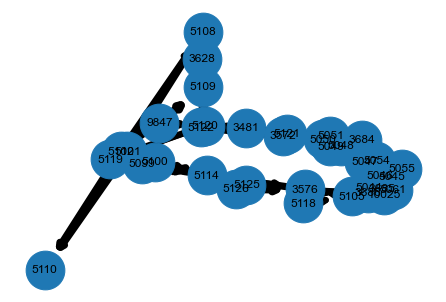

In [1]:
from graph_traffic.get_data import get_graph, ubs_index, plot_graph
from graph_traffic.model_selection import get_node_ids

ids_list = get_node_ids(longitud_lims=(-3.744399888121435, -3.73088591780862),
                   latitud_lims=(40.383067309465936, 40.3904))
ubs, ubs_dict = ubs_index(ids_list)
graph = get_graph(ubs, ubs_dict, weight_threshold=0.5)[0]
plot_graph(graph, ids_list=ids_list)

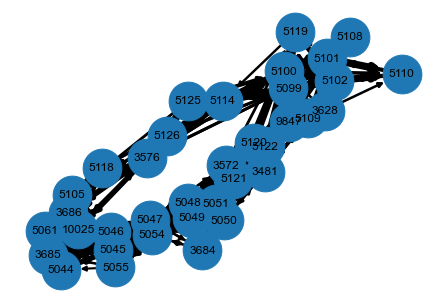

In [2]:
graph = get_graph(ubs, ubs_dict, weight_threshold=0.2)[0]
plot_graph(graph, ids_list=ids_list)

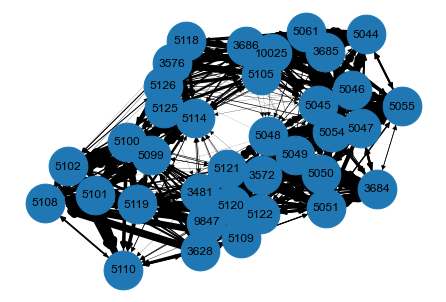

In [3]:
graph = get_graph(ubs, ubs_dict, weight_threshold=0.01)[0]
plot_graph(graph, ids_list=ids_list)

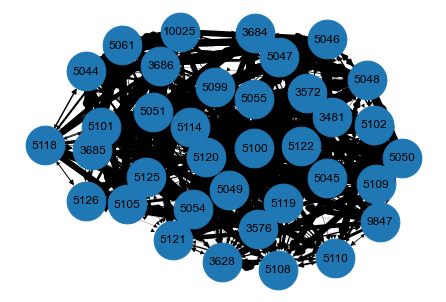

In [4]:
graph = get_graph(ubs, ubs_dict, weight_threshold=0)[0]
plot_graph(graph, ids_list=ids_list)